In [1]:
from xgboost import XGBRegressor
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


from skopt.space import Real, Integer
from skopt import BayesSearchCV
import requests
import json
from entsoe import EntsoePandasClient

from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import check_y

from astral.sun import sun
from astral import LocationInfo
import data

c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset =  "../datasets/energy_dataset.csv"
df = data.load_data(dataset=dataset,daily = None)
df2 = data.preprocessing(df)



In [2]:
df2 = data.load_data(dataset = "../energy_updated.csv")
df2 = data.preprocessing(df2)
df2.rename({"Actual Load":"total load actual"},axis=1, inplace=True)
df2.head


<bound method NDFrame.head of                            ('Biomass', 'Actual Aggregated')  \
time                                                          
2021-12-31 23:00:00+00:00                             526.0   
2022-01-01 00:00:00+00:00                             533.0   
2022-01-01 01:00:00+00:00                             524.0   
2022-01-01 02:00:00+00:00                             532.0   
2022-01-01 03:00:00+00:00                             528.0   
...                                                     ...   
2023-12-31 18:00:00+00:00                             228.0   
2023-12-31 19:00:00+00:00                             236.0   
2023-12-31 20:00:00+00:00                             244.0   
2023-12-31 21:00:00+00:00                             240.0   
2023-12-31 22:00:00+00:00                             248.0   

                           ('Fossil Brown coal/Lignite', 'Actual Aggregated')  \
time                                                                 

In [3]:

#"2023-03-01 23:00:00+00:00"
#'2023-06-30 23:00:00+00:00'
trainx,testx,trainy,testy, end_validation = data.split_data(df2,"total load actual","2017-06-30 23:00:00+00:00",'2018-03-31 23:00:00+00:00')


testx.head

<bound method NDFrame.head of                            generation biomass  \
time                                            
2018-03-31 23:00:00+00:00               269.0   
2018-04-01 00:00:00+00:00               271.0   
2018-04-01 01:00:00+00:00               280.0   
2018-04-01 02:00:00+00:00               280.0   
2018-04-01 03:00:00+00:00               280.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2018-03-31 23:00:00+00:00                                   0.0   
2018-04-01 00:00:00+00:00                                   0.0   
2018-04-01 01:00:00+00:00                                   0.0 

In [4]:
#fourier encoding
def fourier_features(feature,cycle_length,order):
    result = pd.DataFrame()

    k = 2 * np.pi * feature/cycle_length
    for i in range(1,order+1):
        result[f"sin_{feature.name}_{i}"] =  np.sin(i*k)
        result[f"cos_{feature.name}_{i}"]    =  np.cos(i*k)
    return result


In [5]:
weather_df = pd.read_csv("../datasets/weather_features.csv")
weather_df = weather_df.loc[weather_df["city_name"] == "Madrid"]
weather_df.head

<bound method NDFrame.head of                           dt_iso city_name     temp  temp_min  temp_max  \
35145  2015-01-01 00:00:00+01:00    Madrid  267.325   267.325   267.325   
35146  2015-01-01 01:00:00+01:00    Madrid  267.325   267.325   267.325   
35147  2015-01-01 02:00:00+01:00    Madrid  266.186   266.186   266.186   
35148  2015-01-01 03:00:00+01:00    Madrid  266.186   266.186   266.186   
35149  2015-01-01 04:00:00+01:00    Madrid  266.186   266.186   266.186   
...                          ...       ...      ...       ...       ...   
71407  2018-12-31 19:00:00+01:00    Madrid  283.560   282.150   285.150   
71408  2018-12-31 20:00:00+01:00    Madrid  280.120   278.150   281.150   
71409  2018-12-31 21:00:00+01:00    Madrid  278.150   278.150   278.150   
71410  2018-12-31 22:00:00+01:00    Madrid  276.570   276.150   277.150   
71411  2018-12-31 23:00:00+01:00    Madrid  275.150   275.150   275.150   

       pressure  humidity  wind_speed  wind_deg  rain_1h  rain_3h  sn

In [6]:
#Drop duplicates from index
weather_df = weather_df.drop_duplicates(subset="dt_iso")

dups = weather_df["dt_iso"].duplicated()
dups.loc[dups == False]
weather_df


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
35145,2015-01-01 00:00:00+01:00,Madrid,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
35146,2015-01-01 01:00:00+01:00,Madrid,267.325,267.325,267.325,971,63,1,309,0.0,0.0,0.0,0,800,clear,sky is clear,01n
35147,2015-01-01 02:00:00+01:00,Madrid,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
35148,2015-01-01 03:00:00+01:00,Madrid,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
35149,2015-01-01 04:00:00+01:00,Madrid,266.186,266.186,266.186,971,64,1,273,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71407,2018-12-31 19:00:00+01:00,Madrid,283.560,282.150,285.150,1030,88,1,280,0.0,0.0,0.0,0,800,clear,sky is clear,01n
71408,2018-12-31 20:00:00+01:00,Madrid,280.120,278.150,281.150,1031,52,1,260,0.0,0.0,0.0,0,800,clear,sky is clear,01n
71409,2018-12-31 21:00:00+01:00,Madrid,278.150,278.150,278.150,1030,65,1,340,0.0,0.0,0.0,0,800,clear,sky is clear,01n
71410,2018-12-31 22:00:00+01:00,Madrid,276.570,276.150,277.150,1031,69,2,340,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [7]:

temp_features = weather_df["temp"].copy()
temp_features = temp_features.to_frame()
temp_features['temp_roll_mean_1_day'] = temp_features['temp'].rolling(24, closed='left').mean()
temp_features['temp_roll_mean_7_day'] = temp_features['temp'].rolling(24*7, closed='left').mean()
temp_features['temp_roll_max_1_day'] = temp_features['temp'].rolling(24, closed='left').max()
temp_features['temp_roll_min_1_day'] = temp_features['temp'].rolling(24, closed='left').min()
temp_features['temp_roll_max_7_day'] = temp_features['temp'].rolling(24*7, closed='left').max()
temp_features['temp_roll_min_7_day'] = temp_features['temp'].rolling(24*7, closed='left').min()


temp_features.index = df2.index
#temp_features = temp_features.merge(df2["total load actual"],left_index= True, right_index=True)
#temp_features = temp_features.dropna()
temp_features



,temp,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day
time,,,,,,,
2014-12-31 23:00:00+00:00,267.325,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,267.325,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,266.186,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,266.186,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,266.186,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,283.560,278.051667,278.761131,288.34,270.72,288.34,270.72
2018-12-31 19:00:00+00:00,280.120,278.034583,278.765833,288.34,270.72,288.34,270.72
2018-12-31 20:00:00+00:00,278.150,277.981667,278.760833,288.34,270.72,288.34,270.72


In [8]:
location = LocationInfo(
    name='Washington DC',
    region='Spain',
    timezone='CET')

calendar_features = pd.DataFrame(index=df2.index)
calendar_features['month'] = calendar_features.index.month
calendar_features['week_of_year'] = calendar_features.index.isocalendar().week
calendar_features['week_day'] = calendar_features.index.day_of_week + 1
calendar_features['hour_day'] = calendar_features.index.hour + 1
sunrise_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunrise'].hour
    for date in df2.index
]
sunset_hour = [
    sun(location.observer, date=date, tzinfo=location.timezone)['sunset'].hour
    for date in df2.index
]
sun_light_features = pd.DataFrame({
                         'sunrise_hour': sunrise_hour,
                         'sunset_hour': sunset_hour}, 
                         index = df2.index
                     )
sun_light_features['daylight_hours'] = (
    sun_light_features['sunset_hour'] - sun_light_features['sunrise_hour']
)
sun_light_features['is_daylight'] = np.where(
                                        (df2.index.hour >= sun_light_features['sunrise_hour']) & \
                                        (df2.index.hour < sun_light_features['sunset_hour']),
                                        1,
                                        0
                                    )
exo_features = pd.concat([
                            calendar_features,
                            sun_light_features,
                         
                        ], axis=1)

month_encoded = fourier_features(exo_features["month"], 12,1)
week_of_year_encoded = fourier_features(exo_features['week_of_year'], 52,1)
week_day_encoded = fourier_features(exo_features['week_day'], 7,1)
hour_day_encoded = fourier_features(exo_features['hour_day'], 24,1)
cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded,
                    ], axis=1)
cyclical_features = pd.concat([cyclical_features,temp_features], axis = 1)
#cyclical_features = cyclical_features.join(temp_features["temp"])
exo_features = pd.concat([exo_features, cyclical_features], axis=1)
exo_features

,month,week_of_year,week_day,hour_day,sunrise_hour,sunset_hour,daylight_hours,is_daylight,sin_month_1,cos_month_1,...,cos_week_day_1,sin_hour_day_1,cos_hour_day_1,temp,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,12,1,3,24,8,16,8,0,-2.449294e-16,1.000000,...,-0.900969,-2.449294e-16,1.000000,267.325,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,1,1,4,1,8,16,8,0,5.000000e-01,0.866025,...,-0.900969,2.588190e-01,0.965926,267.325,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,1,1,4,2,8,16,8,0,5.000000e-01,0.866025,...,-0.900969,5.000000e-01,0.866025,266.186,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,1,1,4,3,8,16,8,0,5.000000e-01,0.866025,...,-0.900969,7.071068e-01,0.707107,266.186,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,1,1,4,4,8,16,8,0,5.000000e-01,0.866025,...,-0.900969,8.660254e-01,0.500000,266.186,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,12,1,1,19,8,16,8,0,-2.449294e-16,1.000000,...,0.623490,-9.659258e-01,0.258819,283.560,278.051667,278.761131,288.34,270.72,288.34,270.72
2018-12-31 19:00:00+00:00,12,1,1,20,8,16,8,0,-2.449294e-16,1.000000,...,0.623490,-8.660254e-01,0.500000,280.120,278.034583,278.765833,288.34,270.72,288.34,270.72
2018-12-31 20:00:00+00:00,12,1,1,21,8,16,8,0,-2.449294e-16,1.000000,...,0.623490,-7.071068e-01,0.707107,278.150,277.981667,278.760833,288.34,270.72,288.34,270.72


In [9]:

exo_features.iloc[30000]

month                          6.0
week_of_year                  22.0
week_day                       7.0
hour_day                      24.0
sunrise_hour                   3.0
sunset_hour                   20.0
daylight_hours                17.0
is_daylight                    0.0
sin_month_1                    0.0
cos_month_1                   -1.0
sin_week_of_year_1        0.464723
cos_week_of_year_1       -0.885456
sin_week_day_1                -0.0
cos_week_day_1                 1.0
sin_hour_day_1                -0.0
cos_hour_day_1                 1.0
temp                        291.01
temp_roll_mean_1_day    290.489167
temp_roll_mean_7_day    289.684062
temp_roll_max_1_day         296.39
temp_roll_min_1_day         284.13
temp_roll_max_7_day         297.13
temp_roll_min_7_day        283.937
Name: 2018-06-03 23:00:00+00:00, dtype: Float64

In [11]:
transformer_poly = PolynomialFeatures(
                       degree           = 2,
                       interaction_only = True,
                       include_bias     = False,
                       

                   ).set_output(transform="pandas")
"""    'sin_sunrise_hour_1',
    'cos_sunrise_hour_1',
    'sin_sunset_hour_1',
    'cos_sunset_hour_1',"""
poly_cols = [
    'sin_month_1', 
    'cos_month_1',
    'sin_week_of_year_1',
    'cos_week_of_year_1',
    'sin_week_day_1',
    'cos_week_day_1',
    'sin_hour_day_1',
    'cos_hour_day_1',
    'daylight_hours',
    'is_daylight',
    'temp_roll_mean_1_day',
    'temp_roll_mean_7_day',
    'temp_roll_max_1_day',
    'temp_roll_min_1_day',
    'temp_roll_max_7_day',
    'temp_roll_min_7_day',
    'temp'

]

poly_features = transformer_poly.fit_transform(exo_features[poly_cols].dropna())
poly_features = poly_features.drop(columns=poly_cols)
poly_features.columns = [f"poly_{col}" for col in poly_features.columns]
poly_features.columns = poly_features.columns.str.replace(" ", "__")

exo_features = pd.concat([exo_features, poly_features], axis=1)
exo_features


,month,week_of_year,week_day,hour_day,sunrise_hour,sunset_hour,daylight_hours,is_daylight,sin_month_1,cos_month_1,...,poly_temp_roll_max_1_day__temp_roll_min_1_day,poly_temp_roll_max_1_day__temp_roll_max_7_day,poly_temp_roll_max_1_day__temp_roll_min_7_day,poly_temp_roll_max_1_day__temp,poly_temp_roll_min_1_day__temp_roll_max_7_day,poly_temp_roll_min_1_day__temp_roll_min_7_day,poly_temp_roll_min_1_day__temp,poly_temp_roll_max_7_day__temp_roll_min_7_day,poly_temp_roll_max_7_day__temp,poly_temp_roll_min_7_day__temp
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,12,1,3,24,8,16,8,0,-2.449294e-16,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,1,1,4,1,8,16,8,0,5.000000e-01,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,1,1,4,2,8,16,8,0,5.000000e-01,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,1,1,4,3,8,16,8,0,5.000000e-01,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,1,1,4,4,8,16,8,0,5.000000e-01,0.866025,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,12,1,1,19,8,16,8,0,-2.449294e-16,1.000000,...,78059.4048,83139.9556,78059.4048,81761.6904,78059.4048,73289.3184,76765.3632,78059.4048,81761.6904,76765.3632
2018-12-31 19:00:00+00:00,12,1,1,20,8,16,8,0,-2.449294e-16,1.000000,...,78059.4048,83139.9556,78059.4048,80769.8008,78059.4048,73289.3184,75834.0864,78059.4048,80769.8008,75834.0864
2018-12-31 20:00:00+00:00,12,1,1,21,8,16,8,0,-2.449294e-16,1.000000,...,78059.4048,83139.9556,78059.4048,80201.7710,78059.4048,73289.3184,75300.7680,78059.4048,80201.7710,75300.7680


In [17]:
features = []
# Columns that ends with _sin or _cos are selected
features.extend(exo_features.filter(regex='^sin_|^cos_').columns.tolist())
# columns that start with temp_ are selected
features.extend(exo_features.filter(regex='^temp_.*').columns.tolist())
# Columns that start with holiday_ are selected
features.extend(['temp'])
exo_features = exo_features.filter(features, axis=1)

df2 = df2[["total load actual"]].merge(
           exo_features,
           left_index=True,
           right_index=True,
           how='left'
       )

In [36]:
features

['sin_month_1',
 'cos_month_1',
 'sin_week_of_year_1',
 'cos_week_of_year_1',
 'sin_week_day_1',
 'cos_week_day_1',
 'sin_hour_day_1',
 'cos_hour_day_1',
 'temp_roll_mean_1_day',
 'temp_roll_mean_7_day',
 'temp_roll_max_1_day',
 'temp_roll_min_1_day',
 'temp_roll_max_7_day',
 'temp_roll_min_7_day',
 'temp']

In [19]:

df2 = df2.dropna()
df2


,total load actual,sin_month_1,cos_month_1,sin_week_of_year_1,cos_week_of_year_1,sin_week_day_1,cos_week_day_1,sin_hour_day_1,cos_hour_day_1,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,temp
time,,,,,,,,,,,,,,,,
2015-01-07 23:00:00+00:00,26788.0,5.000000e-01,0.866025,0.239316,0.970942,0.433884,-0.900969,-2.449294e-16,1.000000,272.493379,273.132717,282.42,267.212,286.642,265.442,268.0590
2015-01-08 00:00:00+00:00,25146.0,5.000000e-01,0.866025,0.239316,0.970942,-0.433884,-0.900969,2.588190e-01,0.965926,272.462879,273.137086,282.42,267.212,286.642,265.442,267.7175
2015-01-08 01:00:00+00:00,23889.0,5.000000e-01,0.866025,0.239316,0.970942,-0.433884,-0.900969,5.000000e-01,0.866025,272.418150,273.139423,282.42,267.212,286.642,265.442,267.3760
2015-01-08 02:00:00+00:00,23046.0,5.000000e-01,0.866025,0.239316,0.970942,-0.433884,-0.900969,7.071068e-01,0.707107,272.407733,273.146506,282.42,267.212,286.642,265.442,267.3760
2015-01-08 03:00:00+00:00,22587.0,5.000000e-01,0.866025,0.239316,0.970942,-0.433884,-0.900969,8.660254e-01,0.500000,272.397316,273.153589,282.42,267.212,286.642,265.442,267.3760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,30653.0,-2.449294e-16,1.000000,0.120537,0.992709,0.781831,0.623490,-9.659258e-01,0.258819,278.051667,278.761131,288.34,270.720,288.340,270.720,283.5600
2018-12-31 19:00:00+00:00,29735.0,-2.449294e-16,1.000000,0.120537,0.992709,0.781831,0.623490,-8.660254e-01,0.500000,278.034583,278.765833,288.34,270.720,288.340,270.720,280.1200
2018-12-31 20:00:00+00:00,28071.0,-2.449294e-16,1.000000,0.120537,0.992709,0.781831,0.623490,-7.071068e-01,0.707107,277.981667,278.760833,288.34,270.720,288.340,270.720,278.1500


In [11]:
#skforecast
forecast = ForecasterAutoreg(regressor = XGBRegressor(random_state = 1543),lags = 10)
forecast.fit(y=trainy)
forecast


ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=1543, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variab

In [14]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecast,
                          y                  = df2["total load actual"],
                          steps              = 7,
                          metric             = 'mean_absolute_percentage_error',
                          initial_train_size = len(trainy),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10201
Number of observations used for backtesting: 7319
    Number of folds: 1046
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 4 observations.

Fold: 0
    Training:   2021-12-31 23:00:00+00:00 -- 2023-03-01 23:00:00+00:00  (n=10201)
    Validation: 2023-03-02 00:00:00+00:00 -- 2023-03-02 06:00:00+00:00  (n=7)
Fold: 1
    Training:   2021-12-31 23:00:00+00:00 -- 2023-03-01 23:00:00+00:00  (n=10201)
    Validation: 2023-03-02 07:00:00+00:00 -- 2023-03-02 13:00:00+00:00  (n=7)
Fold: 2
    Training:   2021-12-31 23:00:00+00:00 -- 2023-03-01 23:00:00+00:00  (n=10201)
    Validation: 2023-03-02 14:00:00+00:00 -- 2023-03-02 20:00:00+00:00  (n=7)
Fold: 3
    Training:   2021-12-31 23:00:00+00:00 -- 2023-03-01 23:00:00+00:00  (n=10201)
    Validation: 2023-03-02 21:00:00+00:00 --

100%|██████████| 1046/1046 [00:03<00:00, 293.10it/s]


,pred
2023-03-02 00:00:00+00:00,26091.246094
2023-03-02 01:00:00+00:00,24884.556641
2023-03-02 02:00:00+00:00,24209.814453
2023-03-02 03:00:00+00:00,23877.984375
2023-03-02 04:00:00+00:00,24134.087891


In [15]:
print(f'Backtest error (MAE): {metric}')

Backtest error (MAE): 0.0228532380977935


In [13]:
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space
search_params = {
    "reg__max_depth": Integer(2,8),
    "reg__learning_rate": Real(0.001,0.1,prior="log-uniform"),
    "reg__subsample": Real(0.5,1.0),
    "reg__reg_alpha": Real(0.0,10.0),
    "reg__reg_lambda": Real(0.0,10.0),
    "reg__gamma": Real(0.0,10.0)

}

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecast,
                                   y                  = y.loc[:end_validation], # Test data not used
                                   search_space       = search_space,
                                   lags_grid          = lags_grid,
                                   steps              = 36,
                                   refit              = False,
                                   metric             = 'mean_absolute_error',
                                   initial_train_size = len(trainy),
                                   fixed_train_size   = False,
                                   n_trials           = 10, # Increase this value for a more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

Number of models compared: 30,
         10 bayesian search in each lag configuration.


lags grid: 100%|██████████| 3/3 [02:54<00:00, 58.31s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.12115721224645952, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.7000000000000001}
  Backtesting metric: 926.7714194726025



In [103]:
features = []
features.extend(exo_features.filter(regex='sin_|cos_').columns.tolist())
#exo_features =  exo_features.filter(features, axis=1)
exo_features =  exo_features.filter(regex='sin_|cos_', axis=1)
exo_features = exo_features.loc[:,~exo_features.columns.duplicated()].copy()
df3 = pd.DataFrame

df3 = pd.concat([df2["total load actual"],exo_features])
df3.rename(columns={0: 'total load actual'}, inplace=True)

exo_features["total actual load"] = df2["total load actual"]
exo_features.columns

Index(['sin_month_1', 'cos_month_1', 'sin_week_of_year_1',
       'cos_week_of_year_1', 'sin_week_day_1', 'cos_week_day_1',
       'sin_hour_day_1', 'cos_hour_day_1', 'poly_sin_month_1__cos_month_1',
       'poly_sin_month_1__sin_week_of_year_1',
       ...
       'poly_sin_hour_day_1__temp_roll_min_7_day', 'poly_sin_hour_day_1__temp',
       'poly_cos_hour_day_1__temp_roll_mean_1_day',
       'poly_cos_hour_day_1__temp_roll_mean_7_day',
       'poly_cos_hour_day_1__temp_roll_max_1_day',
       'poly_cos_hour_day_1__temp_roll_min_1_day',
       'poly_cos_hour_day_1__temp_roll_max_7_day',
       'poly_cos_hour_day_1__temp_roll_min_7_day', 'poly_cos_hour_day_1__temp',
       'total actual load'],
      dtype='object', length=109)

In [19]:
features = []
features.extend(exo_features.filter(regex='sin_|cos_').columns.tolist())
features.extend(exo_features.filter(regex='^temp_.*').columns.tolist())
features.extend(['temp'])
exo_features =  exo_features.filter(features, axis=1)
df3 = pd.DataFrame
"""df2 = df2["total load actual"].merge(exo_features,
           left_index=True,
           right_index=True,
           how='left')"""

df3 = pd.concat([df2["total load actual"],exo_features])
#df3 = df3.dropna()
df3.rename(columns={0: 'total load actual'}, inplace=True)

exo_features["total actual load"] = df2["total load actual"]
df3.iloc[2000]


total load actual       33112.0
sin_month_1                <NA>
cos_month_1                <NA>
sin_week_of_year_1         <NA>
cos_week_of_year_1         <NA>
sin_week_day_1             <NA>
cos_week_day_1             <NA>
sin_hour_day_1             <NA>
cos_hour_day_1             <NA>
temp_roll_mean_1_day       <NA>
temp_roll_mean_7_day       <NA>
temp_roll_max_1_day        <NA>
temp_roll_min_1_day        <NA>
temp_roll_max_7_day        <NA>
temp_roll_min_7_day        <NA>
temp                       <NA>
Name: 2015-03-25 07:00:00+00:00, dtype: Float64

In [21]:
#model trained using exogenous features
"""
features = []
features.extend(exo_features.filter(regex='sin_|cos_').columns.tolist())
features.extend(exo_features.filter(regex='^temp_.*').columns.tolist())
features.extend(['temp'])
exo_features =  exo_features.filter(features, axis=1)
df3 = pd.DataFrame


df3 = pd.concat([df2["total load actual"],exo_features])
df3 = df3.dropna()
df3.rename(columns={0: 'total load actual'}, inplace=True)

exo_features["total actual load"] = df2["total load actual"]"""

#"2023-03-01 23:00:00+00:00",'2023-06-30 23:00:00+00:00'
#end_train = "2017-06-30 23:00:00+00:00"
#end_validation = '2018-03-31 23:00:00+00:00'

#traintrainx,testx,trainy,testy, end_validation = data.split_data(df3,"total load actual","2017-06-30 23:00:00+00:00",'2018-03-31 23:00:00+00:00')

forecast = ForecasterAutoreg(regressor = XGBRegressor(random_state = 1543),lags = 10)
forecast.fit(y=trainy)

# Lags grid
lags_grid = [[1, 2, 3, 23, 24, 25, 167, 168, 169]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators' : trial.suggest_int('n_estimators', 800, 1400, step=100),
        'max_depth'    : trial.suggest_int('max_depth', 3, 8, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'    : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'   : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecast,
                                   y                  = df2.loc[:end_validation, "total load actual"],
                                   exog               = df2.loc[:end_validation, features],
                                   #y                  = temp_features.loc[:end_validation, "total load actual"],
                                   #exog               = temp_features.loc[:end_validation, temp_features.columns!="total load actual"],
                                   search_space       = search_space,
                                   lags_grid          = lags_grid,
                                   steps              = 36,
                                   refit              = False,
                                   metric             = 'mean_absolute_error',
                                   #len(trainy)
                                   initial_train_size = len(df2.loc[: "2017-06-30 23:00:00+00:00"]),
                                   fixed_train_size   = False,
                                   n_trials           = 20,
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = 'auto',
                                   verbose            = False,
                                   show_progress      = True
                               )

Number of models compared: 20,
         20 bayesian search in each lag configuration.


lags grid: 100%|██████████| 1/1 [02:49<00:00, 169.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 1300, 'max_depth': 4, 'learning_rate': 0.07349251260979461, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}
  Backtesting metric: 1611.0093584269503



In [26]:
#exo = temp_features.drop("total load actual",axis = 1)
metric, predictions = backtesting_forecaster(
                          forecaster         = forecast,
                          y                  = df2["total load actual"],
                          exog               = df2[features],
                          steps              = 7,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df2.loc[: end_validation]),
                          refit              = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

print(f"Backtest error: {metric:.2f}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 28297
Number of observations used for backtesting: 6599
    Number of folds: 943
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 5 observations.

Fold: 0
    Training:   2015-01-07 23:00:00+00:00 -- 2018-03-31 23:00:00+00:00  (n=28297)
    Validation: 2018-04-01 00:00:00+00:00 -- 2018-04-01 06:00:00+00:00  (n=7)
Fold: 1
    Training:   2015-01-07 23:00:00+00:00 -- 2018-03-31 23:00:00+00:00  (n=28297)
    Validation: 2018-04-01 07:00:00+00:00 -- 2018-04-01 13:00:00+00:00  (n=7)
Fold: 2
    Training:   2015-01-07 23:00:00+00:00 -- 2018-03-31 23:00:00+00:00  (n=28297)
    Validation: 2018-04-01 14:00:00+00:00 -- 2018-04-01 20:00:00+00:00  (n=7)
Fold: 3
    Training:   2015-01-07 23:00:00+00:00 -- 2018-03-31 23:00:00+00:00  (n=28297)
    Validation: 2018-04-01 21:00:00+00:00 -- 

100%|██████████| 943/943 [00:05<00:00, 162.54it/s]


Backtest error: 721.59


2018-04-01 00:00:00+00:00    23575.671875
2018-04-01 01:00:00+00:00    22737.212891
2018-04-01 02:00:00+00:00    22454.978516
2018-04-01 03:00:00+00:00    22518.123047
2018-04-01 04:00:00+00:00    23586.361328
2018-04-01 05:00:00+00:00    26040.250000
2018-04-01 06:00:00+00:00    28944.080078
2018-04-01 07:00:00+00:00    30955.242188
2018-04-01 08:00:00+00:00    31799.638672
2018-04-01 09:00:00+00:00    32246.902344
2018-04-01 10:00:00+00:00    32274.863281
2018-04-01 11:00:00+00:00    31918.773438
2018-04-01 12:00:00+00:00    31011.982422
2018-04-01 13:00:00+00:00    30127.226562
2018-04-01 14:00:00+00:00    29437.001953
2018-04-01 15:00:00+00:00    29139.455078
2018-04-01 16:00:00+00:00    28756.505859
2018-04-01 17:00:00+00:00    28958.041016
2018-04-01 18:00:00+00:00    30152.609375
2018-04-01 19:00:00+00:00    31665.779297
2018-04-01 20:00:00+00:00    30135.195312
2018-04-01 21:00:00+00:00    27974.931641
2018-04-01 22:00:00+00:00    26449.181641
2018-04-01 23:00:00+00:00    24669

<AxesSubplot: >

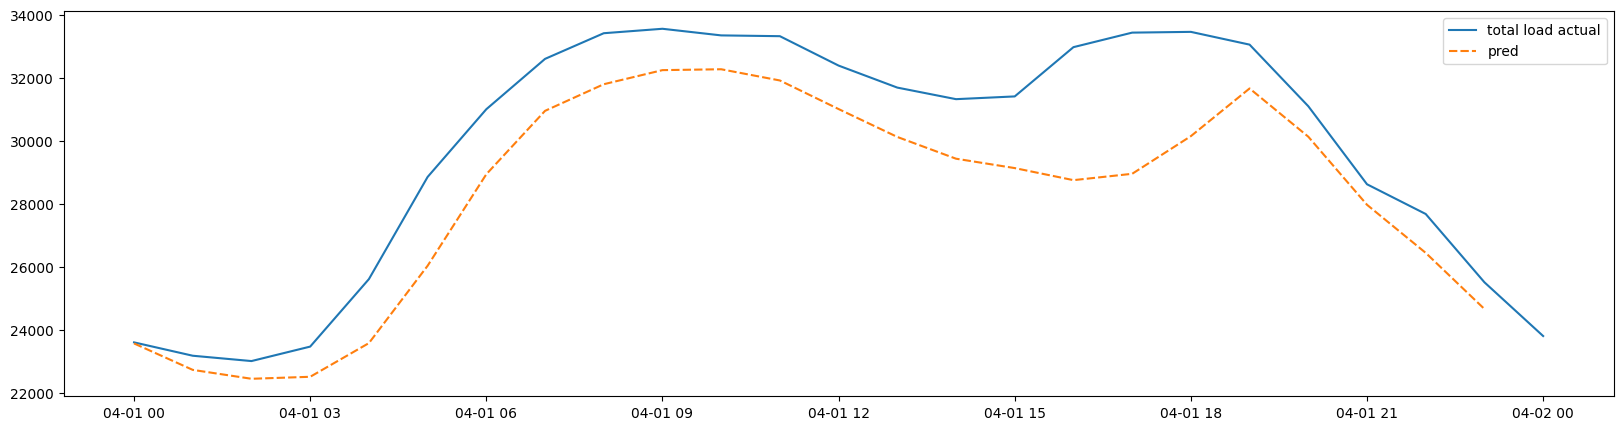

In [35]:
predicted2 = forecast.predict(steps=24,exog = df2.loc["2018-04-01 00:00:00+00:00":,features])
#predicted2.index = testy.iloc[:10].index
#predicted2 = predicted2.index(testy.iloc[:10].index)
print(predicted2)
#print(testy.iloc[:10])
data2 = pd.concat([df2.loc["2018-04-01 00:00:00+00:00":"2018-04-02 00:00:00+00:00","total load actual"],predicted2],axis=1)
print(data2)

fig,ax = plt.subplots(figsize=[20,5])
seaborn.lineplot(ax = ax, data = data2)
